In [48]:
from pandas import Series
series = Series.from_csv('trans_merged.csv', header=0)
series=series["2007":"2016"]
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 108, Validation 12


/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:3727: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [49]:
## Step 1
from pandas import Series
import numpy as np
from statsmodels.tsa.stattools import adfuller
 
# create a differe
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return Series(diff)
 
series = Series.from_csv('dataset.csv')
series=np.log(series)
X = series.values
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')

ADF Statistic: -7.671113
p-value: 0.000000
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583


/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


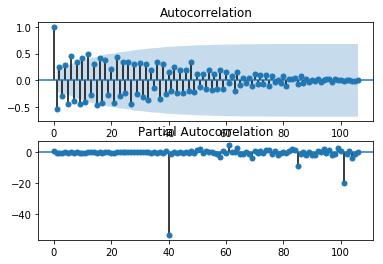

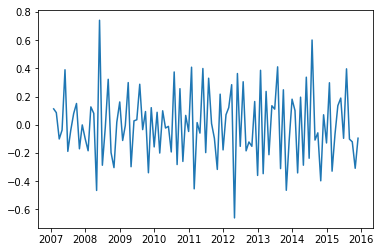

In [50]:
## Step 2 
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import matplotlib.pylab as plt
series = Series.from_csv('stationary.csv')
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()
plt.plot(series)

In [51]:
## Step 3
from pandas import Series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
# load data
series = Series.from_csv('dataset.csv')
series=np.log(series)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(1,1,1))
	model_fit = model.fit(disp=0)
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# 	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(np.exp(test), np.exp(predictions))
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


RMSE: 1818.959


In [52]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import numpy
 
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
 
ARIMA.__getnewargs__ = __getnewargs__
 
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
# transform data
transformed, lam = boxcox(X)
# fit model
model = ARIMA(transformed, order=(0,1,2))
model_fit = model.fit(disp=0)
# save model
model_fit.save('model.pkl')
numpy.save('model_lambda.npy', [lam])

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:3727: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)
/opt/conda/lib/python3.6/site-packages/scipy/stats/morestats.py:900: RuntimeWarning: overflow encountered in square
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))


In [53]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMAResults
from math import exp
from math import log
import numpy
 
# invert box-cox transform
def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)
 
model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
print('Predicted: %.3f' % yhat)

Predicted: 6939.442


/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:3727: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)
/opt/conda/lib/python3.6/site-packages/scipy/stats/morestats.py:900: RuntimeWarning: overflow encountered in square
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))


>Predicted=6939.442, Expected=5924
>Predicted=6858.067, Expected=6053
>Predicted=6826.253, Expected=5771
>Predicted=6710.388, Expected=8082
>Predicted=7107.816, Expected=6349
>Predicted=6807.688, Expected=6146
>Predicted=6727.306, Expected=7425
>Predicted=6925.560, Expected=8854
>Predicted=7164.464, Expected=10788
>Predicted=7560.835, Expected=7815
>Predicted=7138.461, Expected=6776
>Predicted=6922.748, Expected=7865
RMSE: 1417.383


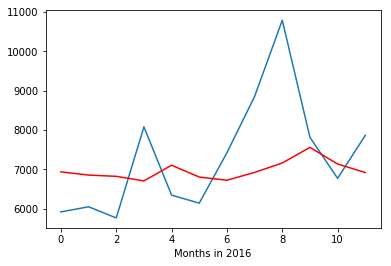

In [56]:
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import exp
from math import log
import numpy
 
# invert box-cox transform
def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)
 
# load and prepare datasets
dataset = Series.from_csv('dataset.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
validation = Series.from_csv('validation.csv')
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')
# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# transform
	transformed, lam = boxcox(history)
	if lam < -5:
		transformed, lam = history, 1
	# predict
	model = ARIMA(transformed, order=(1,1,1))
	model_fit = model.fit(disp=0)
	yhat = model_fit.forecast()[0]
	# invert transformed prediction
	yhat = boxcox_inverse(yhat, lam)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.xlabel("Months in 2016")
pyplot.label("Months in 2016")
pyplot.show()

In [55]:
### Persistence
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# 	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 2201.821


/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:3727: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [46]:
###   Grid Search 

# import warnings
# from pandas import Series
# from statsmodels.tsa.arima_model import ARIMA
# from sklearn.metrics import mean_squared_error
# from math import sqrt
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
# def evaluate_arima_model(X, arima_order):
# 	# prepare training dataset
# 	X = X.astype('float32')
# 	train_size = int(len(X) * 0.50)
# 	train, test = X[0:train_size], X[train_size:]
# 	history = [x for x in train]
# 	# make predictions
# 	predictions = list()
# 	for t in range(len(test)):
# 		model = ARIMA(history, order=arima_order)
# 		model_fit = model.fit(disp=0)
# 		yhat = model_fit.forecast()[0]
# 		predictions.append(yhat)
# 		history.append(test[t])
# 	# calculate out of sample error
# 	mse = mean_squared_error(test, predictions)
# 	rmse = sqrt(mse)
# 	return rmse
 
# # evaluate combinations of p, d and q values for an ARIMA model
# def evaluate_models(dataset, p_values, d_values, q_values):
# 	dataset = dataset.astype('float32')
# 	best_score, best_cfg = float("inf"), None
# 	for p in p_values:
# 		for d in d_values:
# 			for q in q_values:
# 				order = (p,d,q)
# 				try:
# 					mse = evaluate_arima_model(dataset, order)
# 					if mse < best_score:
# 						best_score, best_cfg = mse, order
# 					print('ARIMA%s MSE=%.3f' % (order,mse))
# 				except:
# 					continue
# 	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 
# # load dataset
# series = Series.from_csv('dataset.csv')
# # evaluate parameters
# p_values = range(0,13)
# d_values = range(0, 4)
# q_values = range(0, 13)
# warnings.filterwarnings("ignore")
# evaluate_models(series.values, p_values, d_values, q_values)

In [47]:
validation

2016-01-01     5923.914556
2016-02-01     6053.080400
2016-03-01     5770.686527
2016-04-01     9459.558700
2016-05-01     6348.526954
2016-06-01     6146.197798
2016-07-01     7424.986953
2016-08-01     8853.651622
2016-09-01    10788.054996
2016-10-01     7815.418203
2016-11-01     6775.716265
2016-12-01     7865.240278
dtype: float64